In [2]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


warnings.filterwarnings('ignore')

## Import Data

In [3]:
telescopes = ['12-meter','alma','apex','aste','iram','jcmt','lmt','sma','smt','spt']

In [13]:
starttime = datetime(2019,10,24,6)
endtime = datetime(2019,11,3,18) # not included
timestamps = np.arange(starttime, endtime, 
                       timedelta(hours=6)).astype(datetime)
databook = {}
for site in telescopes:
    databook[site] = dict.fromkeys(timestamps)

In [14]:
for site in telescopes:
    for t in timestamps:
        filepath = "data/"+ site +"/"+ t.strftime("%Y%m%d_%H:%M:%S")
        try:
            df = pd.read_csv(filepath, delim_whitespace=True, skiprows = 1, header = None)
            df.columns = ["date", "tau225", "Tb[k]", "pwv[mm]", "lwp[kg*m^-2]","iwp[kg*m^-2]","o3[DU]"]
            df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d_%H:%M:%S")
            databook[site][t] = df
        except FileNotFoundError:
            databook[site][t] = None
# databook is a dictionary of dictionaries of dataframes 
# keys: telescope names
# values: dictionaries of dataframes for one telescope
# databook[telescope_name] is a dictionary of dataframes for one telescope
# keys: timestamps when the forecast is made
# values: forecast dataframe (None if missing)

In [5]:
# ################## fake data ###################
# actual_time_span = np.arange(datetime(2019,7,1,0), datetime(2019,10,22,6), 
#                        timedelta(hours=6)).astype(datetime)

# i = 0
# for site in telescopes:
#     for t in timestamps:
#         actual_time = actual_time_span[i]
#         time_delta = t - actual_time
#         filepath = "data/MaunaKea/"+ actual_time.strftime("%Y%m%d_%H:%M:%S")
#         df = pd.read_csv(filepath, delim_whitespace=True, skiprows = 1, header = None)
#         df.columns = ["date", "tau225", "Tb[k]", "pwv[mm]", "lwp[kg*m^-2]","iwp[kg*m^-2]","o3[DU]"]
#         df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d_%H:%M:%S") + time_delta
#         databook[site][t] = df
#         i += 1

All our available data is stored in `databook`(a dict of dictionaries):

`databook` indexing:

`databook[telescope_name][timestamp]` is a dataframe of the 16-day forward forecast made at `timestamp` for `telescope_name`. See example below:

In [15]:
print(telescopes[0],timestamps[1])
(databook[telescopes[0]][timestamps[1]]).head()

12-meter 2019-10-24 12:00:00


,date,tau225,Tb[k],pwv[mm],lwp[kg*m^-2],iwp[kg*m^-2],o3[DU]
0,2019-10-24 12:00:00,0.31668,79.716,5.9495,0.0,0.0,282.59
1,2019-10-24 13:00:00,0.32052,80.388,5.9895,0.0,0.0,281.08
2,2019-10-24 14:00:00,0.28490,73.006,5.3674,0.0,0.0,281.57
3,2019-10-24 15:00:00,0.25685,67.094,4.8535,0.0,0.0,283.75
4,2019-10-24 16:00:00,0.23848,63.162,4.5244,0.0,0.0,285.60


## Visualize forecast

For the EDA below, we use the data for telescope('apex') as an example. 

In [16]:
data_telescope = databook['apex']

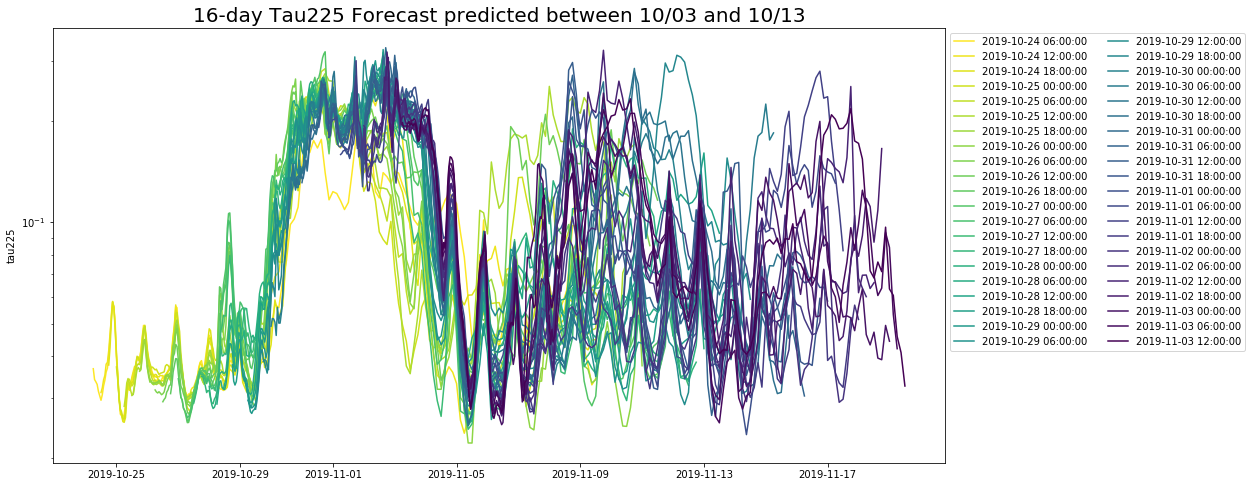

In [17]:
import matplotlib.cm as cm
#cycle through colors from a continuous color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(1,0,len(timestamps))))

plt.figure(figsize = (16,8))
for t in data_telescope:
    df = data_telescope[t]
    if df is not None:
        mask = df['tau225']!=0
        plt.plot(df['date'][mask], df['tau225'][mask], label=t)
plt.legend(ncol = 2,bbox_to_anchor=(1, 1))
plt.title("16-day Tau225 Forecast predicted between 10/03 and 10/13",fontsize = 20)
plt.ylabel("tau225")
plt.yscale('log')
plt.show()

With the use of color map, we denotes the more recent the prediction the deeper

As we can see, there are some really high spikes. Are these outliers? (need to be validated)

Zoom in a little bit:

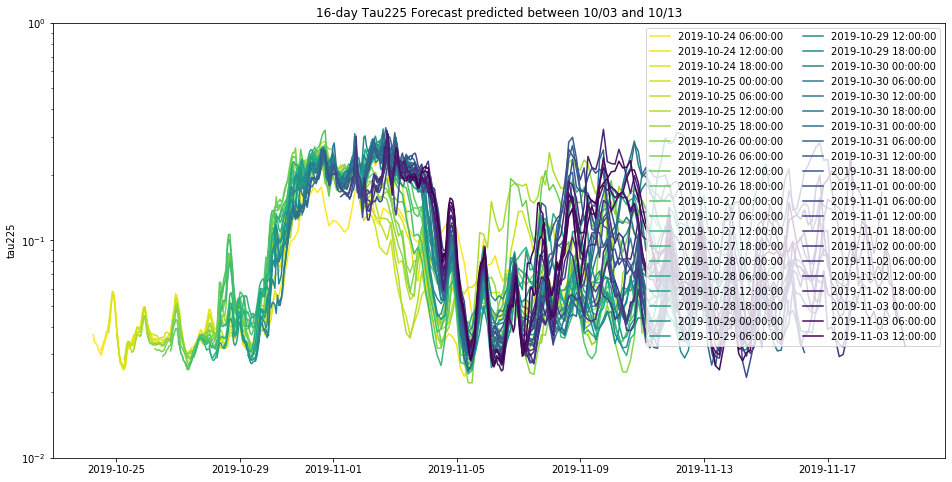

In [19]:
plt.figure(figsize = (16,8))
for t in data_telescope:
    df = data_telescope[t]
    if df is not None:
        mask = df['tau225']!=0
        plt.plot(df['date'][mask], df['tau225'][mask], label=t)
plt.legend(ncol = 2)
plt.title("16-day Tau225 Forecast predicted between 10/03 and 10/13")
plt.ylabel("tau225")
plt.yscale('log')
plt.ylim(0.01,1)
plt.show()

It seems that the forecast has some variance.

## Compute variance

1. Variance v.s. date of prediction

For each date/hour, we have been making prediction of it since 16 days before that date/hour. How does those different predictions about the atmosphere condition at the same datetime vary? Knowing that may give us an overall sense of how accurate the forecast is.

We still use the weather prediction for 'apex' as the example to compute the variance.

In [20]:
df_all = pd.concat([data_telescope[t] for t in data_telescope], axis =0)
df_tau_all = df_all.groupby('date').agg({'tau225':lambda x: list(x)})

df_tau_all['tau225_mean'] = df_tau_all['tau225'].apply(lambda x: np.mean(x))
df_tau_all['tau225_min'] = df_tau_all['tau225'].apply(lambda x: np.min(x))
df_tau_all['tau225_max'] = df_tau_all['tau225'].apply(lambda x: np.max(x))
df_tau_all['tau225_true'] = df_tau_all['tau225'].apply(lambda x: x[-1])
df_tau_all['tau225_latest'] = df_tau_all['tau225'].apply(lambda x: x[-2] if len(x)>1 else x[-1])
df_tau_all['tau225_var'] = df_tau_all['tau225'].apply(lambda x: np.var(x))
df_tau_all.reset_index(inplace = True)

In [21]:
df_tau_all.iloc[20:25]

,date,tau225,tau225_mean,tau225_min,tau225_max,tau225_true,tau225_latest,tau225_var
20,2019-10-25 02:00:00,"[0.030181, 0.030541000000000002, 0.02987099999...",0.030176,0.029871,0.030541,0.030112,0.029871,5.759269e-08
21,2019-10-25 03:00:00,"[0.026957, 0.027629, 0.027738, 0.027932]",0.027564,0.026957,0.027932,0.027932,0.027738,1.345935e-07
22,2019-10-25 04:00:00,"[0.026670999999999997, 0.026931, 0.02669800000...",0.026911,0.026671,0.027345,0.027345,0.026698,7.293119e-08
23,2019-10-25 05:00:00,"[0.026307, 0.025883, 0.025599, 0.026144]",0.025983,0.025599,0.026307,0.026144,0.025599,7.208819e-08
24,2019-10-25 06:00:00,"[0.026923000000000002, 0.02586, 0.025481999999...",0.026556,0.025482,0.028418,0.028418,0.026096,1.090245e-06


Here we re-arrange the dataframe. Each row collected all the prediction for the time in 'date' as a list (here we only use 'tau225' for now. We also calculate the mean, range(min, max) and use the last prediction value as the true weather condition(predicting the weather on the time we are on now), and the second last prediction as the latest prediction.

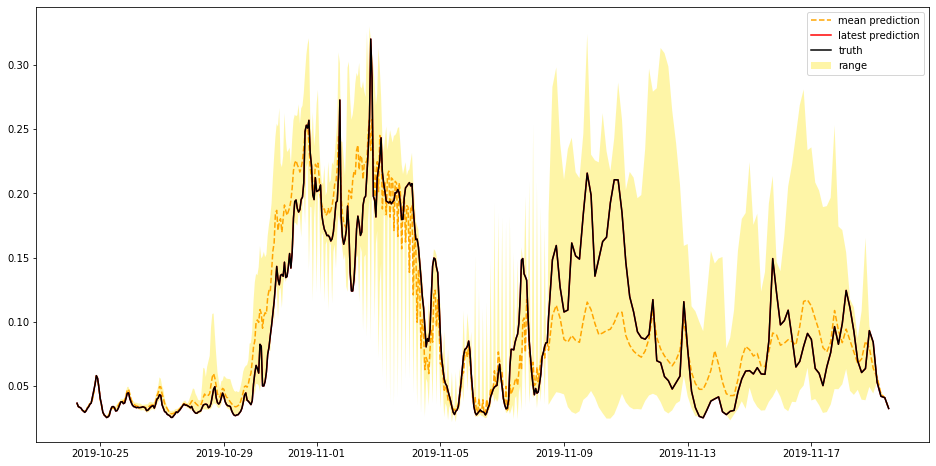

In [22]:
plt.figure(figsize = (16,8))
plt.plot(df_tau_all.date, df_tau_all.tau225_mean, c = 'orange', ls = '--', label = 'mean prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_latest, c = 'r', label = 'latest prediction')
plt.plot(df_tau_all.date, df_tau_all.tau225_latest, c = 'black', label = 'truth')
plt.fill_between(df_tau_all.date.values, df_tau_all.tau225_max, df_tau_all.tau225_min, alpha = 0.4, label = 'range');
plt.legend();

Here we use the yellow area to denote the range, blue represents the lastest prediction and red represnts the weather predictions. 

From the plot above we can see that, we got a range of predictions for each time. Also, the latest prediction for each time also differs from the mean prediction greatly, and also differs from the true weather prediction.

**Small Take-away**
- There are lot of freedom in how to choose the prediction and how to measure the uncertainty.

2. Variance v.s. number of days forward

It makes sense that the further future the GFS model is trying to predict, the less certain it will be. We will estimate the variance of forecast v.s. number of days forward. This could be used as the uncertainty measure for our scheduling strategy.

In [24]:
# concatenate all tau225 for one telescope(apex)
# columns are the timestamps when predictions were made, indices are timestamps that're being predicted
df_tau225 = pd.concat([data_telescope[t].set_index('date')['tau225'] for t in data_telescope if data_telescope[t] is not None],axis = 1)
df_tau225.columns = [t for t in data_telescope if data_telescope[t] is not None]
df_tau225

# use df_mask to record the number of days forward (index - col) for each prediction
df_mask = pd.DataFrame(index = df_tau225.index, columns = df_tau225.columns)
for col in df_tau225.columns:
    df_mask[col] = (df_tau225.index - col).days

# get 'true' tau225 value, which is the closest prediction within a day
true_tau225 = pd.Series(index = df_tau225.index)
for idx in df_tau225.index:
    values = df_tau225.loc[idx]
    true_tau225[idx] = values.values[~values.isna()][-1]

# compute variance v.s. # days forward
df_diff = (df_tau225.T - true_tau225).T
var = []
for i in range(1, df_mask.max().max()+1):
    var.append(np.nanmean(df_diff[df_mask==i].values ** 2))

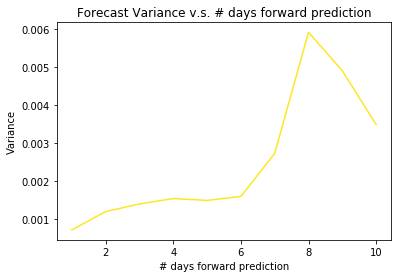

In [25]:
plt.plot(range(1,11), var[:10])
plt.title("Forecast Variance v.s. # days forward prediction")
plt.ylabel("Variance")
plt.xlabel("# days forward prediction")
plt.show()

Overall, it makes sense that the further we want to predict, the larger variance we got. However, we would expect this plot to be a smooth line having upward trend. This ill-behavior might have something to do with the extreme values (zeros and large values) in the data we pulled. As shown in the plot below, the difference beween one-day-forward predictions and the true values is either 0 or very large. This could distort our estimation of the true variance of the forecast.

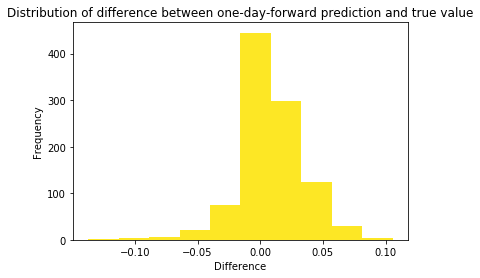

In [26]:
# one day forward prediction
one_day_diff = df_diff[df_mask==1].values
one_day_diff = one_day_diff.reshape(-1)
one_day_diff = one_day_diff[~np.isnan(one_day_diff)]
plt.hist(one_day_diff)
plt.title("Distribution of difference between one-day-forward prediction and true value")
plt.ylabel("Frequency")
plt.xlabel("Difference")
plt.show()